In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

az.style.use("arviz-darkgrid")


HOWELL1_DATA_LOCATION = '../../data/howell1.csv' 

In [2]:
df = pd.read_csv(HOWELL1_DATA_LOCATION)
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Relationship Between Height and Weight

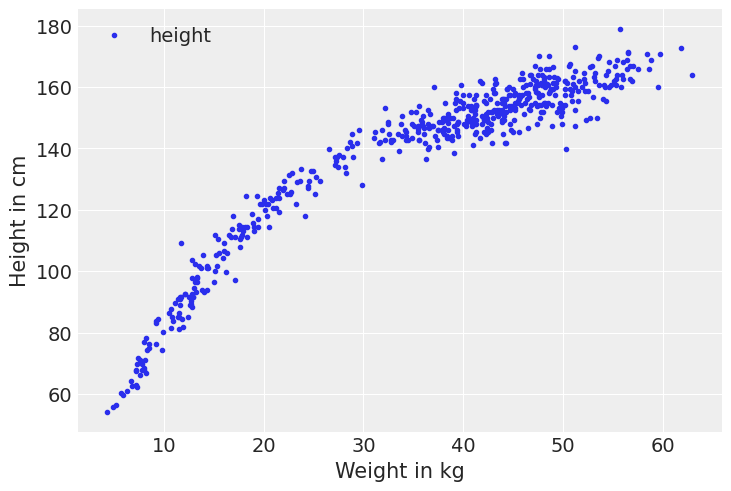

In [3]:
df.plot(x='weight', y='height', style='.')

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

plt.show()

## Parabolic Model for Height vs Weight

We first standardize the weight. To this end, define $z_i = (x_i - \bar{x}) / \text{sd}(x)$. The model is defined as follows:
$$
\begin{align*}
    h_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_1 \cdot z_i + \beta_2 \cdot z_i^2 \\
    \alpha  & \sim N(178, 20) \\
    \beta_1 & \sim \text{Lognormal}(0, 1) \\
    \beta_2 & \sim N(0, 1) \\
    \sigma  & \sim \text{Uniform}(0, 50)
\end{align*}
$$

In [4]:
z = (df['weight'] - df['weight'].mean()) / df['weight'].std()
z_sq = z**2

with pm.Model() as m_quad:
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta_1 = pm.Lognormal('beta_1', mu=0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    mu = pm.Deterministic('mu', alpha + beta_1 * z + beta_2 * z_sq)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    trace_quad = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_2, beta_1, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


### Code 4.66

In [5]:
az.summary(trace_quad, var_names=['alpha', 'beta_1', 'beta_2', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,146.059,0.371,145.477,146.653,0.006,0.004,4019.0,4019.0,4025.0,4959.0,1.0
beta_1,21.733,0.294,21.239,22.168,0.004,0.003,4461.0,4461.0,4455.0,5366.0,1.0
beta_2,-7.802,0.276,-8.268,-7.388,0.005,0.003,3513.0,3513.0,3514.0,4906.0,1.0
sigma,5.807,0.178,5.518,6.081,0.002,0.002,5431.0,5408.0,5482.0,5280.0,1.0


### Code 4.67 and Code 4.68

In [6]:
df_quad = pm.trace_to_dataframe(trace_quad)
df_mu = df_quad.filter(regex=('mu.*'))

df_mu.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__534,mu__535,mu__536,mu__537,mu__538,mu__539,mu__540,mu__541,mu__542,mu__543
0,158.858394,147.391966,140.037560,160.992682,153.377398,159.576282,149.781675,161.311653,144.996750,161.234004,...,158.360139,107.314666,74.620996,144.021490,77.416941,138.720859,160.771709,161.178807,77.515949,160.871213
1,158.724058,147.358865,140.047301,160.813637,153.300850,159.315202,149.732521,161.112115,144.978526,161.042775,...,158.232709,107.463257,74.874656,144.009038,77.662334,138.737519,160.600115,160.991153,77.761047,160.696491
2,158.735070,147.099147,139.779588,161.069004,153.111985,160.246091,149.491398,161.507582,144.709275,161.379234,...,158.213155,107.548185,75.564307,143.738045,78.294880,138.474009,160.809024,161.303159,78.391586,160.924621
3,158.848924,147.893648,140.683197,160.672743,153.690489,158.532433,150.218822,160.830325,145.553008,160.819609,...,158.393752,108.169845,75.405335,144.597594,78.213321,139.386013,160.507403,160.792572,78.312738,160.583742
4,158.488896,147.184573,139.900643,160.553790,153.099637,159.014054,149.548147,160.841445,144.813711,160.776454,...,158.001487,107.412824,74.902983,143.847934,77.684297,138.595420,160.344280,160.726720,77.782783,160.438966


In [7]:
mu_mean = df_mu.apply(np.mean, axis=0)

In [8]:
ht_sim = pm.sampling.sample_posterior_predictive(trace=trace_quad, samples=5000, model=m_quad)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1680: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


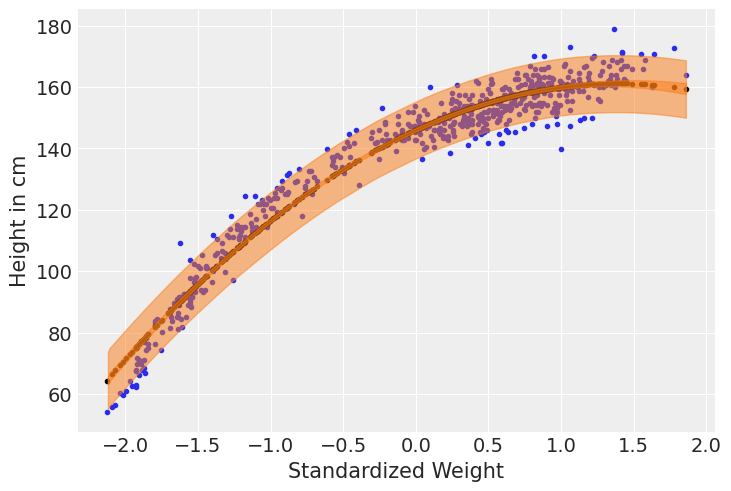

In [9]:
ht_simulated = ht_sim['height']
ht = df['height']
wt = z

_, ax = plt.subplots()

# Raw data
ax.scatter(wt, ht, marker='.')

# Mean mu values as function of weight
ax.scatter(wt, mu_mean, color='k', marker='.')

# Plot the hpd intervals for the height 
az.plot_hdi(wt, np.expand_dims(ht_simulated, 0), hdi_prob=0.89, ax=ax)

# Plot the hpd intervals for the mu values
az.plot_hdi(wt, np.expand_dims(df_mu.values, 0), hdi_prob=0.89, ax=ax)

plt.xlabel('Standardized Weight')
plt.ylabel('Height in cm')

plt.show()

## Cubic Model for Height vs Weight

This involves incorporating a cubic term in the model.
$$
\begin{align*}
    h_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_1 \cdot z_i + \beta_2 \cdot z_i^2 + \beta_3 \cdot z_i^3 \\
    \alpha  & \sim N(178, 20) \\
    \beta_1 & \sim \text{Lognormal}(0, 1) \\
    \beta_2 & \sim N(0, 1) \\
    \sigma  & \sim \text{Uniform}(0, 50)
\end{align*}
$$

### Code 4.69

In [10]:
with pm.Model() as m_cubic:
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    
    beta_1 = pm.Lognormal('beta_1', mu=0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=1)
    
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    mu = pm.Deterministic('mu', alpha + beta_1 * z + beta_2 * z**2 + beta_3 * z**3)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df['height'])
    
    trace_cubic = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_3, beta_2, beta_1, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


In [11]:
df_cubic = pm.trace_to_dataframe(trace_cubic)
df_mu_cubic = df_cubic.filter(regex=('mu.*'))
mu_mean_cubic = df_mu_cubic.apply(np.mean, axis=0)

In [12]:
ht_sim_cubic = pm.sampling.sample_posterior_predictive(trace=trace_cubic, samples=5000, model=m_cubic)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1680: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


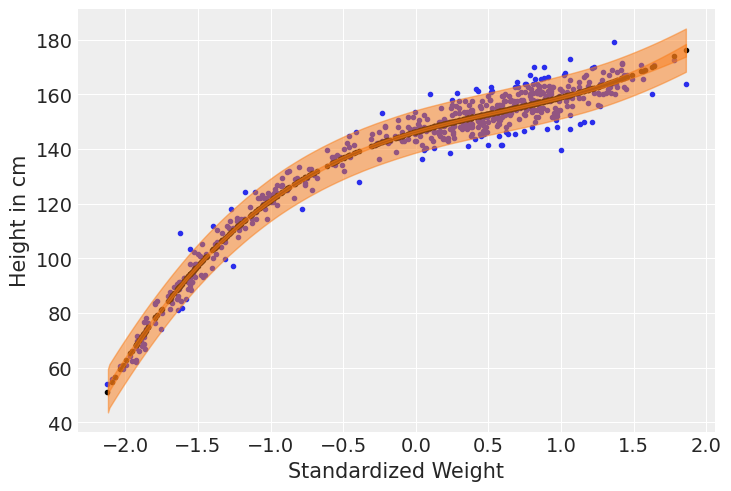

In [13]:
ht_simulated_cubic = ht_sim_cubic['height']
ht = df['height']
wt = z

_, ax = plt.subplots()

# Raw data
ax.scatter(wt, ht, marker='.')

# Mean mu values as function of weight
ax.scatter(wt, mu_mean_cubic, color='k', marker='.')

# Plot the hpd intervals for the height 
az.plot_hdi(wt, np.expand_dims(ht_simulated_cubic, 0), hdi_prob=0.89, ax=ax)

# Plot the hpd intervals for the mu values
az.plot_hdi(wt, np.expand_dims(df_mu_cubic.values, 0), hdi_prob=0.89, ax=ax)

plt.xlabel('Standardized Weight')
plt.ylabel('Height in cm')

plt.show()